In [50]:
import random
import matplotlib.pyplot as plt
import math
from matplotlib.animation import FuncAnimation
import numpy as np
import copy
from SolarYield import *
from IPython.display import clear_output
import pandas as pd

# Fonctions

In [51]:
# Variables solaire
time = []
date = []
P_el_total = []
N = 20 # nombre d'années
Interet = 0.04 # taux d'intérêt
psi = Interet / (1.-(1.+Interet)**(-N))
BPE = 0.150
SPE = 0.050
L = 4.827 # longitude
phi = 50.947 # latitude
albedo = 0.2
Rserie = 1000 # résistance série ATTENTION énoncé erroné
Rpara = 1 # résistance parallèle ATTENTION énoncé erroné
NOCT = 48 # température normale de fonctionnement
I0 = 38*10**(-3) # courant d'éclairement en mA/cm²
G0 = 1000 # irradiation normale
TambOpti = 25 ############## Vmin = ????
Iobs = 1.5*10**(-12) # courant d'obscurité en A/cm²
coefId = 1.2 # coefficient d'idéalité de la diode
NbCellS = 72 # nombre de cellules en série dans un panneau
NbCellP = 1 # nombre de panneaux en parallèle
eVerre = 3 # épaisseur du verre en mm
PrixPV = 300 # prix d'un panneau en euros
UTC = np.arange(0,24,1) # temps universel coordonné

CaractOnduleur = np.zeros((3, 8))
CaractOnduleur[0, :] = [4.5, 9., 1000, 150., 800., 230., 3*6.5, 1213.] # Pacnom, Pdcmax, Vindc, VinMPPT min, Vin MPPT max, Vacout, Iacout, Prix
CaractOnduleur[1, :] = [25 , 37.8, 1000, 580., 850., 230., 3*39.1, 2594.] # Pacnom, Pdcmax, Vindc, VinMPPT min, Vin MPPT max, Vacout, Iacout, Prix
CaractOnduleur[2, :] = [60, 90., 1000, 570., 800., 230., 3*87., 3897.] # Pacnom, Pdcmax, Vindc, VinMPPT min, Vin MPPT max, Vacout, Iacout, Prix

Onduleurs = []
class Onduleur:
    def __init__(self, Pacnom, Pdcmax, Vindc, VinMPPTmin, VinMPPTmax, Vacout, Iacout, Prix):
        self.Pacnom = Pacnom
        self.Pdcmax = Pdcmax
        self.Vindc = Vindc
        self.VinMPPTmin = VinMPPTmin
        self.VinMPPTmax = VinMPPTmax
        self.Vacout = Vacout
        self.Iacout = Iacout
        self.Prix = Prix

# charger les données onduleurs dans Onduleurs
for i in range(0, len(CaractOnduleur)):
    Onduleurs.append(Onduleur(CaractOnduleur[i, 0], CaractOnduleur[i, 1], CaractOnduleur[i, 2], CaractOnduleur[i, 3], CaractOnduleur[i, 4], CaractOnduleur[i, 5], CaractOnduleur[i, 6], CaractOnduleur[i, 7]))

# qCO2Belgique = 0.318*378*10**-3 # kg/MWh
qCO2Belgique = 0.152 # kg/kWh sur la dernière année https://www.electricitymap.org/?page=country&solar=false&remote=true&wind=false&countryCode=BE 
qC02PV = 2000 # kg/kW



In [52]:
def EnergyBalance(time, date, P_dmd, P_nf):

    m = len(date) # the number of lines in P
    n = len(time) # the number of columns in P
    dt = 24. / n

    P_grid = np.zeros((m,n), dtype=float)      # the power imported from the grid
    P_export = np.zeros((m,n), dtype=float)    # the power exported to the grid

    E_grid = 0.
    E_export = 0.
    E_dmd = 0.

    for i in range(m):
        for j in range(n):
            P_export[i,j] = max(P_nf[i,j]-P_dmd[i,j], 0.) # Export excess energy to grid
            P_grid[i,j] = max(P_dmd[i,j]-P_nf[i,j], 0.) # Import required energy from grid

        E_grid += np.trapz(P_grid[i,:], time) 
        E_export += np.trapz(P_export[i,:], time)
        E_dmd += np.trapz(P_dmd[i,:], time)

    return E_grid, E_export, E_dmd

def GetPVProduction():
    Ghprim = [] # créer une liste vide pour stocker le rayonnement global
    Dhprim = [] # créer une liste vide pour stocker le rayonnement diffus
    Tambprim = [] # créer une liste vide pour stocker la température ambiante
    dpm = [31,28,31,30,31,30,31,31,30,31,30]
    PVGISData = open("DataOnshore_be.csv", 'r')
    Buf = PVGISData.readlines()
    n_lines = len(Buf)-17-12
    dt = 1.
    n_step = int(24. / dt)
    n_days = int(n_lines / n_step)
    date = np.arange(0,n_days)
    time = np.arange(0,24,dt)
    j = 0 # index for the time
    k = 0 # index for the day
    Epv = 0. # the energy produced by the PV
    # créer une liste à 2 dimensions pour stocker les données de G et D
    for i in range(n_lines):
        (Buf1, Buf2, Buf3, Buf4, Buf5, Buf6, Buf7, Buf8, Buf9, Buf10) = Buf[i+17].split(',')
        (tmp1, tmp2) = Buf1.split(':')
        yy = tmp1[0:4]
        mm = tmp1[4:6]
        dd = tmp1[6:8]
        h = tmp2[0:2]
        m = tmp2[2:4]
        t_float = float(h)
        j, = np.where(time==t_float)
        k = int(dd)-1+int(np.sum(dpm[0:int(mm)-1]))
        
        Ghprim = np.append(Ghprim, float(Buf4))
        Dhprim = np.append(Dhprim, float(Buf6))
        Tambprim = np.append(Tambprim, float(Buf2))

    Ghprim = np.reshape(Ghprim, (365,24)) # copier P_pv dans un tableau à 2 dimensions
    Dhprim = np.reshape(Dhprim, (365,24)) # copier P_pv dans un tableau à 2 dimensions
    Tambprim = np.reshape(Tambprim, (365,24)) # copier P_pv dans un tableau à 2 dimensions

    return time, date, Ghprim, Dhprim, Tambprim

def PvYield(gamma, i, Nps, Npp, NumOnd, nbinsta):
        P_pv = [] # créer une liste vide pour stocker la production PV
        Epv = 0. # the energy produced by the PV
        for d in range(365):                                                                     
            (a,hprim,TST, h_n, UTC_0, UTC_1) = SunPosition(d, UTC, L, phi)
            (Rs, Rd, theta) = IrradiationRatio(i, gamma, a, hprim, albedo, Gh[d,:], Dh[d,:])
            Gabs = GlassAbsorbtion((Gh[d,:]-Dh[d,:])*Rs, Dh[d,:]*Rd, theta, e = eVerre)
            (Pm, Vm) = PV_panel(Gabs, Tamb[d,:], NOCT = NOCT, Rs = Rpara, Rsh = Rserie, Id0 = Iobs, Iphi0 = I0, G0 = G0, n = coefId , ncs = NbCellS, ncp = NbCellP) # n = coef idealité // Eg = Energy gap (reste constant) et Rsh = resistance parallèle (reste constant)
            Ppv = PV_array(Pm, Vm, Nps, Npp, Onduleurs[int(NumOnd)].Pdcmax, Onduleurs[int(NumOnd)].VinMPPTmax, Onduleurs[int(NumOnd)].VinMPPTmin)*nbinsta # a0, a1, a2 les mêmes et tauloss = ??
            P_pv = np.append(P_pv, Ppv) # ajouter Ppv à P_pv
            Epv += np.trapz(Ppv,UTC)
        P_pv = np.reshape(P_pv, (365,24)) # copier P_pv dans un tableau à 2 dimensions
        return P_pv

def GetProfile():
    dpm = [0,31,28,31,30,31,30,31,31,30,31,30]
    # url = "https://raw.githubusercontent.com/Louis9551/Solaire/main/Groupe1.csv"  # Remplacez par l'URL de votre fichier
    # response = requests.get(url)
    # ConsoData = response.text
    ConsoData = open("Groupe1.csv", 'r')
    Buf = ConsoData.readlines()
    n_lines = len(Buf)
    dt = 1.
    n_step = int(24. / dt)
    n_days = 365
    E_house = np.zeros((n_days,n_step), dtype=float)
    date = np.arange(0,n_days)
    time = np.arange(0,24,dt)

    j = 0 # index for the time
    k = 0 # index for the day
    for i in range(n_lines-1):
        (tmp1, tmp2, Buf1) = Buf[i+1].split(',')
        (yy, mm, dd) = tmp1.split('-')
        (h, m, s) = tmp2.split(':')
        t_float = round(float(h)+float(m)/60.,0)
        j, = np.where(time==t_float)
        k = int(dd)-1+np.sum(dpm[0:int(mm)])
        E_house[k,j[0]] = float(Buf1)
    return time, date, E_house


def LoadDurationCurve(t, d, P, color='blue', name='Power', steps=250):
    m = len(d) # the number of lines in P
    n = len(t) # the number of columns in P
    dt = 24. / n
    
    Psteps = np.linspace(0., np.amax(P)*1.1, num=steps) # the power considered in the cumulative sum
    Tau = np.zeros(steps, dtype=float) # the number of operating hours
    Pflat = np.reshape(P, m*n)
    for i in range(steps, 0, -1): Tau[i-1] = (np.ma.masked_greater_equal(Pflat, Psteps[i-1])).mask.sum()*dt
    E_tot = 0
    for i in range(m): E_tot += np.trapz(P[i,:], t)
        
    P_max = np.amax(Pflat)
    tau_e = E_tot / P_max
    load_factor = tau_e / (m*24.)
    P_avg = P_max * load_factor

    fig, ax = plt.subplots(figsize=(16, 9))
    plt.close(fig)
    ax.fill_between(Tau, Psteps, 0., facecolor=color, alpha=.5, interpolate=True, label=u'%s= %.0f MWh/y' %(name,E_tot/1000.))
    ax.set_xlim(0, m*24.)
    ax.set_ylim(bottom=0)
    ax.set_ylabel('Power [kW]')
    ax.set_xlabel('Time [h/year]')
    ax.grid(True)
    ax.annotate(r'$P_{peak}$ = %.2f kW ($P_{avg}$ = %.2f kW)' %(P_max, P_avg), xy=(0, P_max), xytext=(tau_e/3, P_max),
            arrowprops=dict(facecolor='black', shrink=0.05))
    ax.text(tau_e, P_max/3*2, r'$\tau_e$ = %.0f h/y (load factor= %.2f)' %(tau_e, load_factor))
    ax.legend()
    return fig


# Main

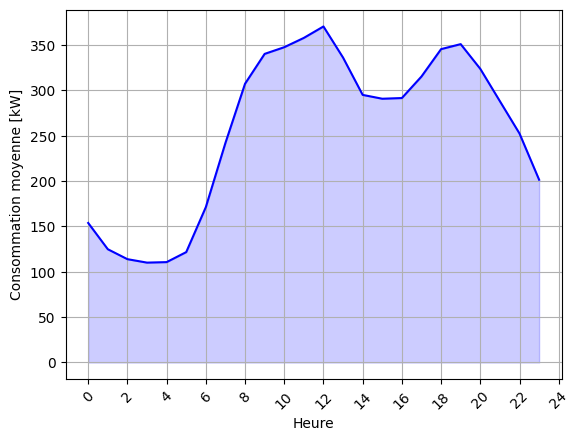

In [53]:
# Charger les données de consommation
(time, date, P_el_total) = GetProfile()

# Calculer la consommation moyenne par heure
P_el_mean = np.mean(P_el_total, axis=0)

# Tracer la consommation moyenne par heure
plt.figure()
plt.fill_between(time, P_el_mean, color='blue', alpha=0.2)
plt.plot(time, P_el_mean, color='blue')
plt.xlabel('Heure')
plt.ylabel('Consommation moyenne [kW]')

# Ajouter un cadrillage
plt.grid(True)

# Modifier l'échelle de l'axe x (par exemple, tous les 2 heures)
plt.xticks(range(0, len(time)+1, 2), rotation=45)  # Vous pouvez ajuster la plage en fonction de vos besoins

plt.show()





# Analyse Pareto

NumOnd      2.000000
Nps        18.000000
Npp        18.000000
gamma     -24.291852
i          27.246982
nbinsta     5.000000
f1          0.130877
f2          0.142087
f3          7.539992
Name: 14, dtype: float64


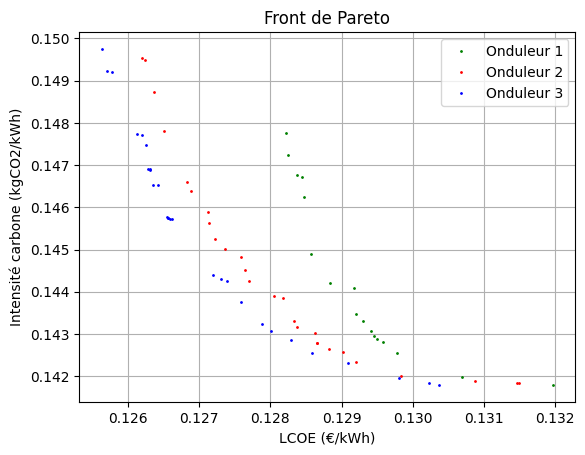

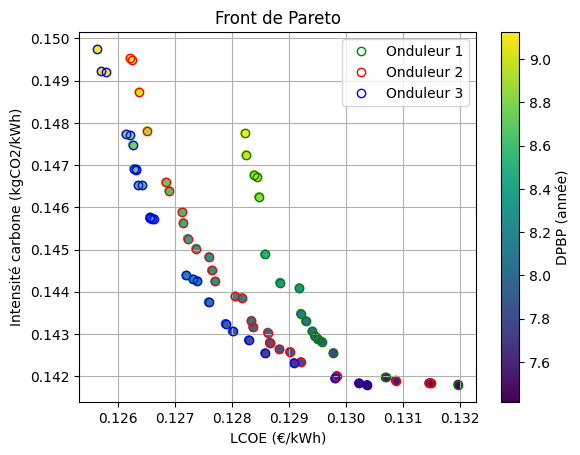

    NumOnd   Nps   Npp      gamma          i  nbinsta        f1        f2  \
0      2.0  18.0  20.0  -8.005378  30.278884      7.0  0.126466  0.146427   
1      2.0  18.0  22.0  -6.925387  28.938121      7.0  0.125855  0.148463   
2      2.0  18.0  22.0  -6.613163  29.812158      6.0  0.126822  0.145220   
3      2.0  18.0  22.0  -6.861207  29.522031      6.0  0.126825  0.145217   
4      2.0  18.0  23.0  -7.955000  31.099825      7.0  0.125639  0.149683   
5      2.0  18.0  22.0  -8.083573  31.091566      7.0  0.125851  0.148542   
6      2.0  18.0  25.0  -7.539269  28.672522      4.0  0.129477  0.142154   
7      2.0  18.0  21.0  -5.662177  27.294160      7.0  0.126179  0.147362   
8      2.0  18.0  23.0  -9.385474  31.071627      5.0  0.127915  0.143239   
9      2.0  18.0  23.0  -4.828934  27.810740      6.0  0.126584  0.145984   
10     2.0  18.0  24.0 -11.604715  29.423375      6.0  0.126310  0.146900   
11     2.0  18.0  21.0 -13.688994  32.086954      5.0  0.128742  0.142447   

In [54]:
# Les données que vous avez fournies
dataOND0 = [
    [0.0, 9.0, 6.0, -17.128058, 26.451448, 48.0, 0.128380, 0.146774, 9.366778],
    [0.0, 10.0, 5.0, -16.385469, 29.297090, 42.0, 0.129296, 0.143304, 8.577441],
    [0.0, 9.0, 6.0, -10.974384, 24.424088, 48.0, 0.128439, 0.146725, 9.380224],
    [0.0, 9.0, 6.0, -18.686170, 28.297900, 50.0, 0.128220, 0.147751, 9.531430],
    [0.0, 6.0, 8.0, -16.408760, 31.216692, 42.0, 0.129505, 0.142873, 8.444406],
    [0.0, 9.0, 6.0, -15.651431, 29.897568, 49.0, 0.128242, 0.147242, 9.436837],
    [0.0, 9.0, 6.0, -3.862253, 28.866580, 47.0, 0.128467, 0.146250, 9.283024],
    [0.0, 11.0, 4.0, -15.615634, 29.997237, 40.0, 0.130695, 0.141971, 8.113966],
    [0.0, 10.0, 5.0, -15.578998, 28.713990, 45.0, 0.128840, 0.144217, 8.806530],
    [0.0, 9.0, 4.0, -13.957937, 31.719478, 44.0, 0.131971, 0.141802, 8.026127],
    [0.0, 10.0, 5.0, -13.933159, 28.481094, 47.0, 0.128575, 0.144888, 8.957825],
    [0.0, 9.0, 5.0, -8.568268, 29.691065, 45.0, 0.129451, 0.142944, 8.478021],
    [0.0, 11.0, 4.0, -19.309413, 27.384956, 48.0, 0.129206, 0.143480, 8.633235],
    [0.0, 7.0, 7.0, 1.442840, 29.517381, 45.0, 0.129181, 0.144086, 8.794645],
    [0.0, 7.0, 7.0, -12.996811, 30.099793, 41.0, 0.129577, 0.142813, 8.436963],
    [0.0, 9.0, 5.0, -13.705765, 34.909070, 43.0, 0.129778, 0.142550, 8.336502],
    [0.0, 7.0, 7.0, -12.900913, 29.264349, 42.0, 0.129407, 0.143064, 8.513046],
]

# Création du DataFrame
dfOND0 = pd.DataFrame(dataOND0, columns=['NumOnd', 'Nps', 'Npp', 'gamma', 'i', 'nbinsta', 'f1', 'f2', 'f3'])


dataOND1 = {
    'NumOnd': [1.0]*27,
    'Nps': [17.0, 18.0, 17.0, 17.0, 17.0, 17.0, 18.0, 16.0, 16.0, 17.0, 17.0, 18.0, 18.0, 17.0, 19.0, 18.0, 17.0, 18.0, 18.0, 18.0, 18.0, 17.0, 16.0, 18.0, 18.0, 17.0, 18.0],
    'Npp': [11.0, 10.0, 10.0, 11.0, 9.0, 10.0, 9.0, 11.0, 11.0, 10.0, 11.0, 10.0, 10.0, 12.0, 10.0, 9.0, 11.0, 11.0, 10.0, 9.0, 10.0, 10.0, 9.0, 10.0, 10.0, 9.0, 10.0],
    'gamma': [-11.928532, -12.953212, -14.664039, -14.150537, -20.052935, -19.849735, -16.141415, -18.414067, -16.556578, -14.83336, -13.991779, -11.860358, -11.618231, -13.391336, -5.950443, -21.532409, -13.603732, -16.136177, -11.181473, -17.180867, -15.696471, -14.098103, -14.581558, -10.230706, -15.320513, -17.14719, -6.632743],
    'i': [29.305097, 29.231752, 29.044251, 31.733324, 34.003834, 37.179867, 27.122568, 35.438074, 33.06953, 27.548904, 29.850127, 34.980254, 34.080022, 33.805944, 29.829625, 28.624888, 33.967073, 34.420177, 32.235899, 33.471279, 30.233648, 30.08904, 29.499599, 33.063284, 28.672839, 33.478793, 36.456789],
    'nbinsta': [15.0, 15.0, 14.0, 13.0, 10.0, 9.0, 14.0, 13.0, 10.0, 15.0, 12.0, 13.0, 14.0, 10.0, 11.0, 10.0, 11.0, 11.0, 16.0, 11.0, 12.0, 11.0, 12.0, 16.0, 16.0, 11.0, 14.0],
    'f1': [0.126363, 0.126506, 0.127218, 0.127141, 0.131495, 0.131461, 0.127642, 0.127591, 0.129835, 0.12683, 0.127699, 0.127365, 0.12689, 0.128624, 0.128337, 0.130873, 0.128367, 0.128054, 0.126197, 0.12866, 0.12883, 0.129205, 0.129014, 0.127122, 0.126242, 0.128661, 0.128173],
    'f2': [0.148729, 0.147804, 0.145257, 0.145631, 0.141834, 0.141837, 0.144505, 0.144827, 0.142008, 0.14659, 0.144245, 0.145023, 0.146395, 0.143034, 0.143315, 0.141898, 0.143161, 0.143889, 0.149523, 0.142794, 0.142639, 0.142337, 0.142579, 0.145894, 0.149494, 0.142793, 0.143853],
    'f3': [9.183984, 9.035174, 8.584071, 8.648967, 7.499684, 7.466427, 8.453486, 8.465442, 7.719324, 8.836977, 8.381768, 8.520334, 8.77891, 8.11084, 8.176978, 7.59778, 8.111013, 8.303655, 9.287429, 8.002667, 7.977603, 7.867452, 7.96324, 8.726376, 9.296745, 8.002865, 8.308461]
}

dfOND1 = pd.DataFrame(dataOND1)

# Additional data
dataOND2 = {
    'NumOnd': [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0],
    'Nps': [15.0, 17.0, 18.0, 18.0, 18.0, 17.0, 18.0, 18.0, 17.0, 17.0, 17.0, 16.0, 16.0, 18.0, 17.0, 17.0, 16.0, 16.0, 17.0, 18.0, 18.0, 18.0, 17.0, 17.0, 18.0, 17.0, 18.0, 17.0],
    'Npp': [25.0, 24.0, 25.0, 21.0, 24.0, 24.0, 22.0, 25.0, 24.0, 25.0, 22.0, 23.0, 24.0, 24.0, 25.0, 24.0, 23.0, 23.0, 24.0, 24.0, 23.0, 23.0, 24.0, 24.0, 23.0, 24.0, 24.0, 24.0],
    'gamma': [-13.594363, -11.856513, -7.202217, -14.777798, -9.483112, -10.346077, -11.765963, -12.737139, -10.637013, -11.260082, -13.272997, -11.973559, -12.235060, -10.659485, -8.041472, -12.455669, -18.360403, -16.256444, -13.214667, -8.032364, -13.067706, -11.757147, -10.896114, -10.723813, -11.851251, -9.849294, -7.629392, -10.315403],
    'i': [32.434249, 29.876012, 28.737862, 34.893586, 32.159037, 30.886403, 34.545069, 30.908651, 27.912431, 26.812837, 33.168306, 31.336083, 31.299747, 32.567327, 30.039388, 30.169790, 29.783695, 34.619461, 31.313827, 30.055548, 30.855690, 32.141097, 28.620018, 27.794752, 31.999471, 25.723756, 31.549812, 30.643752],
    'nbinsta': [7.0, 6.0, 6.0, 7.0, 4.0, 6.0, 5.0, 5.0, 7.0, 6.0, 6.0, 7.0, 5.0, 5.0, 6.0, 6.0, 5.0, 6.0, 4.0, 6.0, 7.0, 5.0, 6.0, 6.0, 4.0, 7.0, 6.0, 5.0],
    'f1': [0.126249, 0.126556, 0.126128, 0.126199, 0.129807, 0.126554, 0.128289, 0.127309, 0.125698, 0.126417, 0.127189, 0.126273, 0.128578, 0.127585, 0.126352, 0.126551, 0.129084, 0.127388, 0.130369, 0.126307, 0.125631, 0.127882, 0.126589, 0.126617, 0.130227, 0.125779, 0.126304, 0.128006],
    'f2': [0.147480, 0.145750, 0.147730, 0.147709, 0.141948, 0.145756, 0.142854, 0.144297, 0.149217, 0.146517, 0.144385, 0.146915, 0.142547, 0.143753, 0.146518, 0.145760, 0.142315, 0.144255, 0.141794, 0.146879, 0.149749, 0.143243, 0.145733, 0.145732, 0.141834, 0.149196, 0.146909, 0.143061],
    'f3': [8.781940, 8.493578, 8.866992, 8.809158, 7.541795, 8.493050, 7.851905, 8.231229, 9.068300, 8.656511, 8.220387, 8.698248, 7.774910, 8.100297, 8.643156, 8.492457, 7.694162, 8.187524, 7.415913, 8.710764, 9.124223, 7.967667, 8.500233, 8.505981, 7.447968, 9.084632, 8.710150, 7.927254]
}

# Creating a DataFrame for the new data
dfOND2 = pd.DataFrame(dataOND2)

# Nouvelles données
dataOND12 = [
    [2.0, 18.0, 20.0, -8.005378, 30.278884, 7.0, 0.126466, 0.146427, 8.635088],
    [2.0, 18.0, 22.0, -6.925387, 28.938121, 7.0, 0.125855, 0.148463, 8.958624],
    [2.0, 18.0, 22.0, -6.613163, 29.812158, 6.0, 0.126822, 0.145220, 8.409185],
    [2.0, 18.0, 22.0, -6.861207, 29.522031, 6.0, 0.126825, 0.145217, 8.409693],
    [2.0, 18.0, 23.0, -7.955000, 31.099825, 7.0, 0.125639, 0.149683, 9.125666],
    [2.0, 18.0, 22.0, -8.083573, 31.091566, 7.0, 0.125851, 0.148542, 8.957846],
    [2.0, 18.0, 25.0, -7.539269, 28.672522, 4.0, 0.129477, 0.142154, 7.650799],
    [2.0, 18.0, 21.0, -5.662177, 27.294160, 7.0, 0.126179, 0.147362, 8.804971],
    [2.0, 18.0, 23.0, -9.385474, 31.071627, 5.0, 0.127915, 0.143239, 7.974749],
    [2.0, 18.0, 23.0, -4.828934, 27.810740, 6.0, 0.126584, 0.145984, 8.567717],
    [2.0, 18.0, 24.0, -11.604715, 29.423375, 6.0, 0.126310, 0.146900, 8.711438],
    [2.0, 18.0, 21.0, -13.688994, 32.086954, 5.0, 0.128742, 0.142447, 7.739389],
    [2.0, 18.0, 23.0, -11.135454, 31.201452, 6.0, 0.126492, 0.146072, 8.548668],
    [2.0, 18.0, 23.0, -9.585702, 29.004378, 7.0, 0.125654, 0.149638, 9.128827],
    [2.0, 18.0, 18.0, -24.291852, 27.246982, 5.0, 0.130877, 0.142087, 7.539992],
    [2.0, 18.0, 24.0, -7.388675, 30.694974, 5.0, 0.127625, 0.143747, 8.108832],
    [2.0, 18.0, 20.0, -6.932721, 31.093333, 6.0, 0.127614, 0.143861, 8.134337],
    [2.0, 18.0, 22.0, -7.572863, 30.490472, 5.0, 0.128359, 0.142835, 7.867189],
    [2.0, 18.0, 20.0, -11.345471, 31.465506, 5.0, 0.129312, 0.142177, 7.646221],
    [2.0, 18.0, 23.0, -3.360413, 25.867248, 7.0, 0.125792, 0.149564, 9.156573],
    [2.0, 18.0, 24.0, -7.179664, 29.602620, 5.0, 0.127628, 0.143731, 8.109429]
]

# Ajout des nouvelles données au DataFrame existant
dfOND12 = pd.DataFrame(dataOND12, columns=['NumOnd', 'Nps', 'Npp', 'gamma', 'i', 'nbinsta', 'f1', 'f2', 'f3'])

# Les données que vous avez fournies
dataOND2TYPE2 = [
    [2.0, 17.0, 26.0, 4.154123, 29.332141, 4.0, 1.0, 1.0, 6.0, -9.477805, 43.333316, 3.0, 0.130424, 0.142679, 7.902816],
    [2.0, 18.0, 30.0, -13.411004, 23.919429, 4.0, 1.0, 1.0, 2.0, 9.684656, 34.286678, 3.0, 0.128715, 0.143846, 8.388429],
    [2.0, 17.0, 26.0, 4.770625, 29.632949, 5.0, 1.0, 1.0, 6.0, -10.227375, 43.785680, 3.0, 0.128252, 0.144571, 8.443193],
    [2.0, 17.0, 23.0, 7.849033, 29.932250, 6.0, 1.0, 1.0, 6.0, -13.214606, 44.530823, 5.0, 0.128108, 0.145788, 8.769811],
    [2.0, 17.0, 25.0, -1.283824, 26.917770, 6.0, 1.0, 1.0, 7.0, -3.095167, 39.618862, 4.0, 0.127153, 0.146969, 8.925091],
    [2.0, 16.0, 30.0, -1.511668, 28.254854, 4.0, 1.0, 1.0, 5.0, -3.751575, 41.202841, 2.0, 0.129388, 0.142826, 7.990566],
    [2.0, 15.0, 30.0, 3.437518, 29.240646, 5.0, 1.0, 1.0, 5.0, -8.862395, 43.051500, 3.0, 0.128174, 0.144836, 8.502271],
    [2.0, 18.0, 27.0, -4.670595, 25.618905, 5.0, 1.0, 1.0, 5.0, 0.776035, 37.571736, 5.0, 0.127823, 0.145912, 8.833905],
    [2.0, 17.0, 26.0, -3.389531, 26.143859, 5.0, 1.0, 1.0, 5.0, -0.694735, 38.401619, 5.0, 0.128337, 0.144512, 8.512395],
    [2.0, 18.0, 27.0, -3.484938, 26.107395, 5.0, 1.0, 1.0, 5.0, -0.586576, 38.343396, 5.0, 0.127818, 0.145913, 8.832868],
    [2.0, 17.0, 27.0, 1.925010, 28.646880, 4.0, 1.0, 1.0, 6.0, -7.067675, 42.168140, 3.0, 0.130005, 0.142768, 7.972172],
    [2.0, 18.0, 27.0, -2.171651, 26.988498, 5.0, 1.0, 1.0, 5.0, -2.324614, 39.608435, 5.0, 0.127808, 0.145916, 8.830651],
    [2.0, 18.0, 24.0, 5.749220, 29.770803, 5.0, 1.0, 1.0, 7.0, -11.192323, 44.085108, 4.0, 0.128653, 0.144477, 8.467369],
    [2.0, 16.0, 27.0, -1.196899, 26.564998, 6.0, 1.0, 1.0, 3.0, -2.963845, 39.170495, 4.0, 0.126945, 0.147066, 8.927918]
]

# Création du DataFrame
dfOND2TYPE2 = pd.DataFrame(dataOND2TYPE2, columns=['NumOnd_1', 'Nps_1', 'Npp_1', 'gamma_1', 'i_1', 'Ninsta_1',
                                       'NumOnd_2', 'Nps_2', 'Npp_2', 'gamma_2', 'i_2', 'Ninsta_2',
                                       'f1', 'f2', 'f3'])


# Trouver l'individu avec le plus petit f3 et en sortir ses valeurs
f3_min_index = dfOND12['f3'].idxmin()
f3_min_values = dfOND12.iloc[f3_min_index]
print(f3_min_values)

# afficher f2 en fonction de f1 pour les 2 bases de données
plt.figure()
plt.plot(dfOND0['f1'], dfOND0['f2'], 'go', markersize=1, label='Onduleur 1' )
plt.plot(dfOND1['f1'], dfOND1['f2'], 'ro', markersize=1, label='Onduleur 2' )
plt.plot(dfOND2['f1'], dfOND2['f2'], 'bo', markersize=1, label='Onduleur 3' )
#plt.plot(dfOND12['f1'], dfOND12['f2'], 'ko', markersize=1, label='Onduleur 2-3' )
#plt.plot(dfOND2TYPE2['f1'], dfOND2TYPE2['f2'], 'ko', markersize=1, label='Onduleur 3, 2 types' )
plt.ylabel('Intensité carbone (kgCO2/kWh)')
plt.xlabel('LCOE (€/kWh)')
plt.title('Front de Pareto')
plt.grid(True)
plt.legend()
plt.show()

# afficher f2 en fonction de f1 et f3 avec des couleurs pour les 2 bases de données
plt.figure()
plt.scatter(dfOND0['f1'], dfOND0['f2'], c=dfOND0['f3'], cmap='viridis')
plt.scatter(dfOND1['f1'], dfOND1['f2'], c=dfOND1['f3'], cmap='viridis')
plt.scatter(dfOND2['f1'], dfOND2['f2'], c=dfOND2['f3'], cmap='viridis')
#plt.scatter(dfOND12['f1'], dfOND12['f2'], c=dfOND12['f3'], cmap='viridis')
#plt.scatter(dfOND2TYPE2['f1'], dfOND2TYPE2['f2'], c=dfOND2['f3'], cmap='viridis')
plt.plot(dfOND0['f1'], dfOND0['f2'], 'go', markerfacecolor = 'none',  label='Onduleur 1')
plt.plot(dfOND1['f1'], dfOND1['f2'], 'ro', markerfacecolor = 'none',  label='Onduleur 2')
plt.plot(dfOND2['f1'], dfOND2['f2'], 'bo', markerfacecolor = 'none', label='Onduleur 3')
#plt.plot(dfOND12['f1'], dfOND12['f2'], 'ko', markerfacecolor = 'none', label='Onduleur 2-3')
#plt.plot(dfOND2TYPE2['f1'], dfOND2TYPE2['f2'], 'ko', markerfacecolor = 'none', label='Onduleur 3, 2 types')
plt.colorbar(label='DPBP (année)')
plt.ylabel('Intensité carbone (kgCO2/kWh)')
plt.xlabel('LCOE (€/kWh)')
plt.title('Front de Pareto')
plt.grid(True)
plt.legend()
plt.show()

print(dfOND12)


# Monotone

NumOnd      2.000000
Nps        17.000000
Npp        24.000000
gamma     -13.214667
i          31.313827
nbinsta     4.000000
f1          0.130369
f2          0.141794
f3          7.415913
Name: 18, dtype: float64


c:\Users\ciold\OneDrive - student.helmo.be\#GRAMME\M2\ENERGIE_SOLAIRE\PROJET\SolarYield.py:89: RuntimeWarning: invalid value encountered in divide
  Rd = np.where( Dh != 0., (1.+np.cos(np.radians(i)))/2. + (1.-np.cos(np.radians(i)))/2. * albedo * np.divide(Gh,Dh), 0.)
c:\Users\ciold\OneDrive - student.helmo.be\#GRAMME\M2\ENERGIE_SOLAIRE\PROJET\SolarYield.py:124: RuntimeWarning: divide by zero encountered in divide
  eta_inv = np.where(P_in_dc > 0, 1. - a0 - a1*np.divide(Prated,P_in_dc) - a2*np.divide(P_in_dc,Prated), 0.)
c:\Users\ciold\OneDrive - student.helmo.be\#GRAMME\M2\ENERGIE_SOLAIRE\PROJET\SolarYield.py:89: RuntimeWarning: divide by zero encountered in divide
  Rd = np.where( Dh != 0., (1.+np.cos(np.radians(i)))/2. + (1.-np.cos(np.radians(i)))/2. * albedo * np.divide(Gh,Dh), 0.)


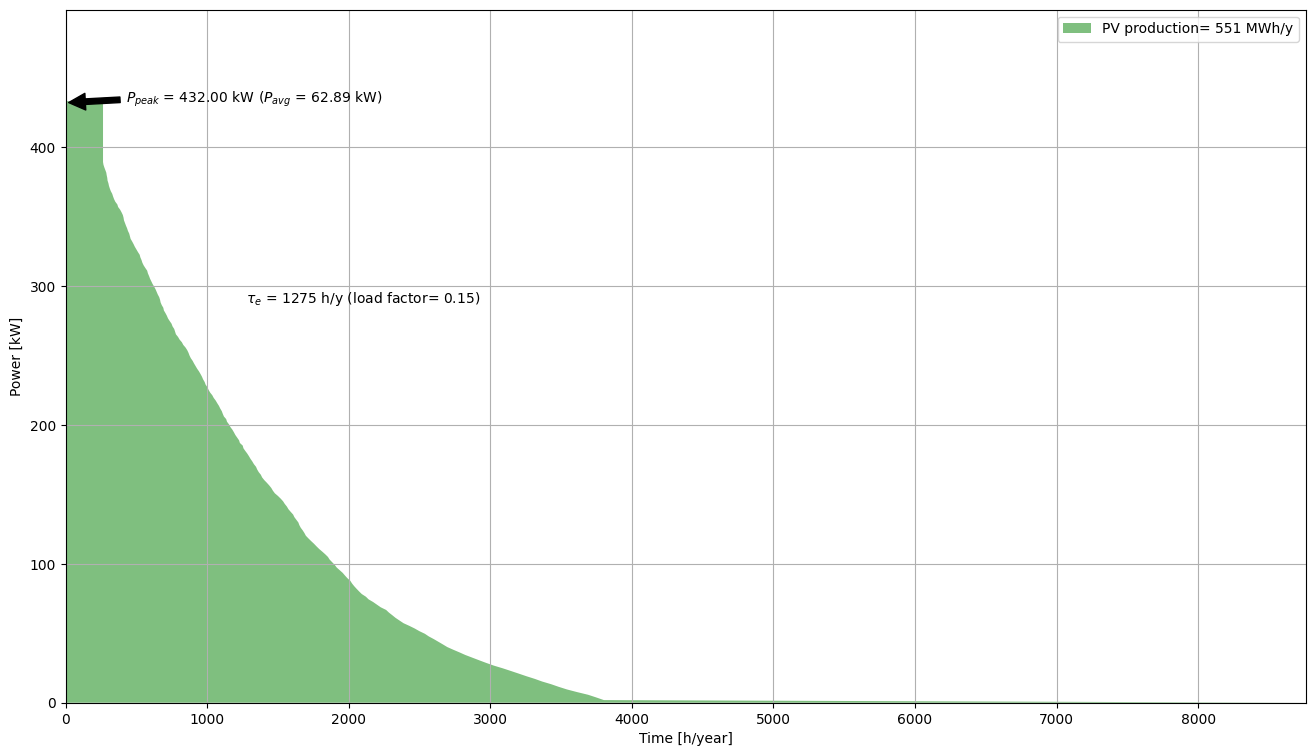

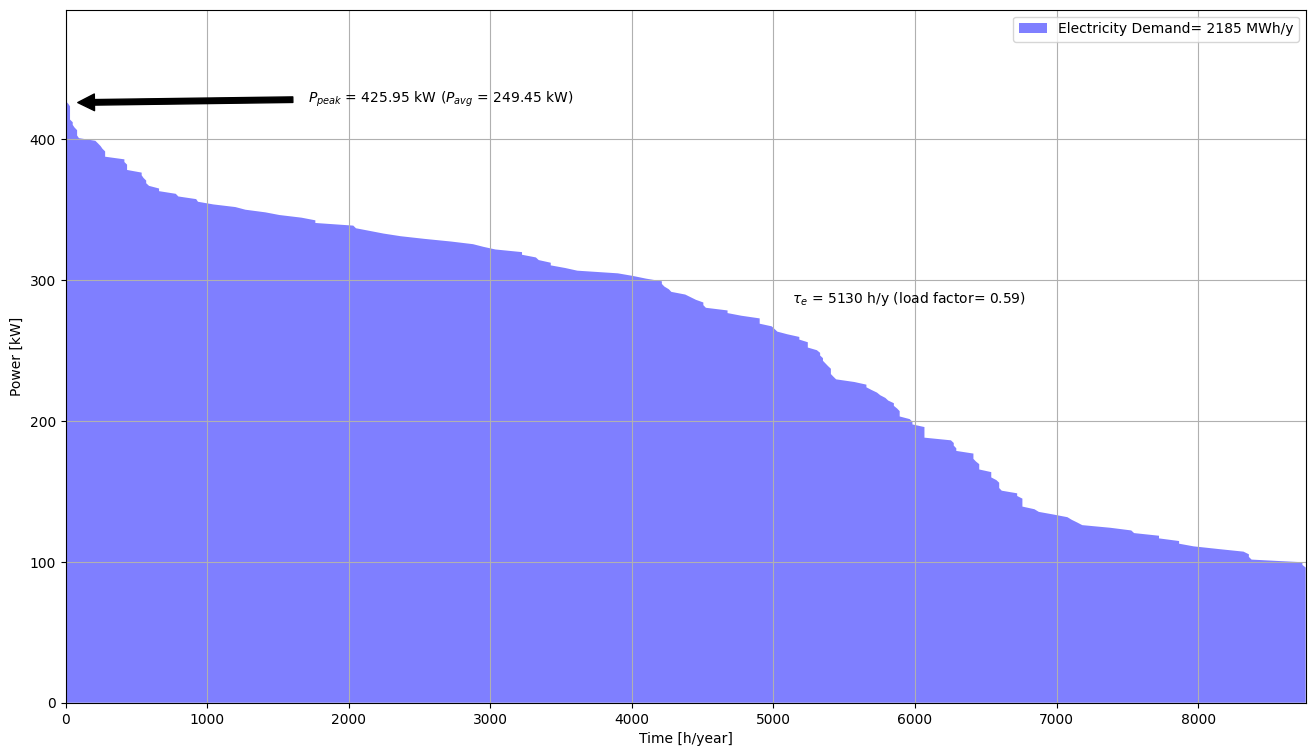

In [55]:
(time, date, P_el_total) = GetProfile()
(time, date, Gh, Dh, Tamb) = GetPVProduction()

dataOND1 = {
    'NumOnd': [1.0]*27,
    'Nps': [17.0, 18.0, 17.0, 17.0, 17.0, 17.0, 18.0, 16.0, 16.0, 17.0, 17.0, 18.0, 18.0, 17.0, 19.0, 18.0, 17.0, 18.0, 18.0, 18.0, 18.0, 17.0, 16.0, 18.0, 18.0, 17.0, 18.0],
    'Npp': [11.0, 10.0, 10.0, 11.0, 9.0, 10.0, 9.0, 11.0, 11.0, 10.0, 11.0, 10.0, 10.0, 12.0, 10.0, 9.0, 11.0, 11.0, 10.0, 9.0, 10.0, 10.0, 9.0, 10.0, 10.0, 9.0, 10.0],
    'gamma': [-11.928532, -12.953212, -14.664039, -14.150537, -20.052935, -19.849735, -16.141415, -18.414067, -16.556578, -14.83336, -13.991779, -11.860358, -11.618231, -13.391336, -5.950443, -21.532409, -13.603732, -16.136177, -11.181473, -17.180867, -15.696471, -14.098103, -14.581558, -10.230706, -15.320513, -17.14719, -6.632743],
    'i': [29.305097, 29.231752, 29.044251, 31.733324, 34.003834, 37.179867, 27.122568, 35.438074, 33.06953, 27.548904, 29.850127, 34.980254, 34.080022, 33.805944, 29.829625, 28.624888, 33.967073, 34.420177, 32.235899, 33.471279, 30.233648, 30.08904, 29.499599, 33.063284, 28.672839, 33.478793, 36.456789],
    'nbinsta': [15.0, 15.0, 14.0, 13.0, 10.0, 9.0, 14.0, 13.0, 10.0, 15.0, 12.0, 13.0, 14.0, 10.0, 11.0, 10.0, 11.0, 11.0, 16.0, 11.0, 12.0, 11.0, 12.0, 16.0, 16.0, 11.0, 14.0],
    'f1': [0.126363, 0.126506, 0.127218, 0.127141, 0.131495, 0.131461, 0.127642, 0.127591, 0.129835, 0.12683, 0.127699, 0.127365, 0.12689, 0.128624, 0.128337, 0.130873, 0.128367, 0.128054, 0.126197, 0.12866, 0.12883, 0.129205, 0.129014, 0.127122, 0.126242, 0.128661, 0.128173],
    'f2': [0.148729, 0.147804, 0.145257, 0.145631, 0.141834, 0.141837, 0.144505, 0.144827, 0.142008, 0.14659, 0.144245, 0.145023, 0.146395, 0.143034, 0.143315, 0.141898, 0.143161, 0.143889, 0.149523, 0.142794, 0.142639, 0.142337, 0.142579, 0.145894, 0.149494, 0.142793, 0.143853],
    'f3': [9.183984, 9.035174, 8.584071, 8.648967, 7.499684, 7.466427, 8.453486, 8.465442, 7.719324, 8.836977, 8.381768, 8.520334, 8.77891, 8.11084, 8.176978, 7.59778, 8.111013, 8.303655, 9.287429, 8.002667, 7.977603, 7.867452, 7.96324, 8.726376, 9.296745, 8.002865, 8.308461]
}

dfOND1 = pd.DataFrame(dataOND1)

# Additional data
dataOND2 = {
    'NumOnd': [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0],
    'Nps': [15.0, 17.0, 18.0, 18.0, 18.0, 17.0, 18.0, 18.0, 17.0, 17.0, 17.0, 16.0, 16.0, 18.0, 17.0, 17.0, 16.0, 16.0, 17.0, 18.0, 18.0, 18.0, 17.0, 17.0, 18.0, 17.0, 18.0, 17.0],
    'Npp': [25.0, 24.0, 25.0, 21.0, 24.0, 24.0, 22.0, 25.0, 24.0, 25.0, 22.0, 23.0, 24.0, 24.0, 25.0, 24.0, 23.0, 23.0, 24.0, 24.0, 23.0, 23.0, 24.0, 24.0, 23.0, 24.0, 24.0, 24.0],
    'gamma': [-13.594363, -11.856513, -7.202217, -14.777798, -9.483112, -10.346077, -11.765963, -12.737139, -10.637013, -11.260082, -13.272997, -11.973559, -12.235060, -10.659485, -8.041472, -12.455669, -18.360403, -16.256444, -13.214667, -8.032364, -13.067706, -11.757147, -10.896114, -10.723813, -11.851251, -9.849294, -7.629392, -10.315403],
    'i': [32.434249, 29.876012, 28.737862, 34.893586, 32.159037, 30.886403, 34.545069, 30.908651, 27.912431, 26.812837, 33.168306, 31.336083, 31.299747, 32.567327, 30.039388, 30.169790, 29.783695, 34.619461, 31.313827, 30.055548, 30.855690, 32.141097, 28.620018, 27.794752, 31.999471, 25.723756, 31.549812, 30.643752],
    'nbinsta': [7.0, 6.0, 6.0, 7.0, 4.0, 6.0, 5.0, 5.0, 7.0, 6.0, 6.0, 7.0, 5.0, 5.0, 6.0, 6.0, 5.0, 6.0, 4.0, 6.0, 7.0, 5.0, 6.0, 6.0, 4.0, 7.0, 6.0, 5.0],
    'f1': [0.126249, 0.126556, 0.126128, 0.126199, 0.129807, 0.126554, 0.128289, 0.127309, 0.125698, 0.126417, 0.127189, 0.126273, 0.128578, 0.127585, 0.126352, 0.126551, 0.129084, 0.127388, 0.130369, 0.126307, 0.125631, 0.127882, 0.126589, 0.126617, 0.130227, 0.125779, 0.126304, 0.128006],
    'f2': [0.147480, 0.145750, 0.147730, 0.147709, 0.141948, 0.145756, 0.142854, 0.144297, 0.149217, 0.146517, 0.144385, 0.146915, 0.142547, 0.143753, 0.146518, 0.145760, 0.142315, 0.144255, 0.141794, 0.146879, 0.149749, 0.143243, 0.145733, 0.145732, 0.141834, 0.149196, 0.146909, 0.143061],
    'f3': [8.781940, 8.493578, 8.866992, 8.809158, 7.541795, 8.493050, 7.851905, 8.231229, 9.068300, 8.656511, 8.220387, 8.698248, 7.774910, 8.100297, 8.643156, 8.492457, 7.694162, 8.187524, 7.415913, 8.710764, 9.124223, 7.967667, 8.500233, 8.505981, 7.447968, 9.084632, 8.710150, 7.927254]
}

# Creating a DataFrame for the new data
dfOND2 = pd.DataFrame(dataOND2)

# Trouver l'individu avec le plus petit f3 et en sortir ses valeurs
f3_min_index = dfOND2['f3'].idxmin()
f3_min_values = dfOND2.iloc[f3_min_index]
print(f3_min_values)

# 0 = NumOnd, 1 = Nps, 2 = Npp, 3 = gamma, 4 = i, 5 = nbinsta
NumIndividu = f3_min_index

dfOND2['gamma'][NumIndividu]
P_PV_Ind = PvYield(dfOND2['gamma'][NumIndividu],dfOND2['i'][NumIndividu], dfOND2['Nps'][NumIndividu], dfOND2['Npp'][NumIndividu],dfOND2['NumOnd'][NumIndividu], dfOND2['nbinsta'][NumIndividu])
LDC_PV = LoadDurationCurve(time, date, P_PV_Ind, color='green', name='PV production', steps=250)
display(LDC_PV)
LDC_elec = LoadDurationCurve(time, date, P_el_total, color='blue', name='Electricity Demand', steps=250)
display(LDC_elec)